In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display

from utils.diagnostics import compute_summary_statistics

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
model_names = ["ew", "mvo", "md", "dlpoo"]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

In [4]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        # read data
        summary = pd.read_csv(os.path.join(output_path, "summary.csv"))
        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["model"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

## 1) Summary Statistics of the Portfolios

In [5]:

all_stats = {}
for model in model_names:

    portfolio_returns = torch.tensor(all_summary_df.loc[all_summary_df["model"] == model].groupby("date").sum()["pnl"])
    stats = compute_summary_statistics(portfolio_returns=portfolio_returns)

    all_stats[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

display(HTML(all_stats_df.to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
ew,5.451658,16.890216,0.322770,0.417997,-6.275493,-27.568665,0.536472
mvo,-22.102618,35.857639,-0.616399,-0.743626,-34.288082,-71.626066,0.500398
md,7.700280,10.646849,0.723245,1.035127,-3.515227,-13.359790,0.533068
dlpoo,2.561089,20.660351,0.123962,0.162732,-12.653598,-41.646692,0.515538


In [6]:
print(all_stats_df.reset_index().to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
index &       E[R] &    Std(R) &    Sharpe &   Sortino &      AvgDD &      MaxDD &  \% Positive Ret. \\
\midrule
   ew &   5.451658 & 16.890216 &  0.322770 &  0.417997 &  -6.275493 & -27.568665 &         0.536472 \\
  mvo & -22.102618 & 35.857639 & -0.616399 & -0.743626 & -34.288082 & -71.626066 &         0.500398 \\
   md &   7.700280 & 10.646849 &  0.723245 &  1.035127 &  -3.515227 & -13.359790 &         0.533068 \\
dlpoo &   2.561089 & 20.660351 &  0.123962 &  0.162732 & -12.653598 & -41.646692 &         0.515538 \\
\bottomrule
\end{tabular}



## 2) Cummulative Returns of the Portfolios

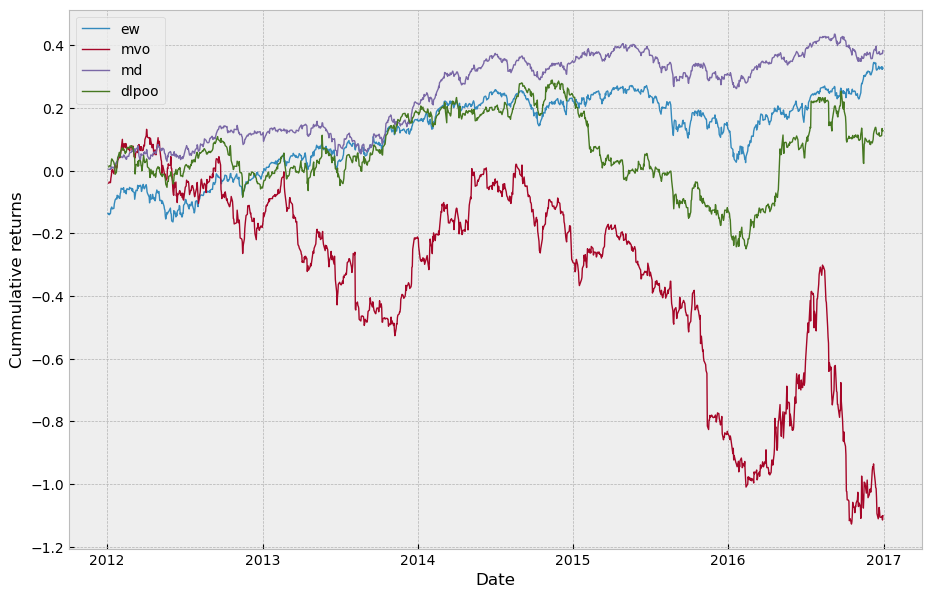

In [7]:

fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["model"] == model]
    cum_pnl_df = summary_df.groupby("date").sum()[["pnl"]].cumsum().loc["2012-01-01":].reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
# fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
plt.show()

## 3) Boxplot with the Sharpe Ratio for each Monte Carlo Sample

## 4) Forecast Comparison - Diebold-Mariano Test